# **Raw Exploration**
---
This notebook performs an in-depth exploratory data analysis (EDA), quality control (QC), and filtering on the raw unfiltered Smart-seq dataset. We analyze both gene- and cell-level statistics to identify low-quality entries, apply filtering criteria, and compare our processed dataset to the instructor-provided version.

## Index

1. [Data Integrity Checks](#1-data-integrity-checks)
2. [Descriptive Statistic](#2-descriptive-statistic)
3. [Sparsity](#3-sparsity)
4. [Outlier Analysis](#4-outlier-analysis)
5. [Filtering Strategy and Dataset Update](#5-filtering)
    1. [QC Metrics](#5.1-qc-metrics)
    2. [Filtering Strategy](#5.2-filtering)
6. [Duplicates Check](#6-duplicate-check)
7. [Normalization](#7-normalization)
8. [Distribution Diagnostic and Log-Transformation](#8-dd-log)
9. [High Variable Gene Selection](#9-hvg)

> *Note:* This notebook is meant for diagnostic and educational purposes. All downstream modeling steps will use the instructor-provided filtered dataset.

In [1]:
import os
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns
from scipy.linalg import qr


In [2]:
dfs_hcc_unfiltered = pd.read_csv("../Data/SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt",sep=r"\s+",engine="python",index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"'))

dfs_hcc_filtered = pd.read_csv( "../Data/SmartSeq/HCC1806_SmartS_Filtered_Data.txt",sep=r"\s+",engine="python",index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"'))

dfs_hcc_train = pd.read_csv("../Data/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt",sep=r"\s+",engine="python",index_col=0).rename(index=lambda x: x.strip('"')).rename(columns=lambda x: x.strip('"'))


## **1.** Data Integrity Checks
---

We will perform the basic data integrity checks of all the datasets we just imported, just to be sure that when we will need them later we will not find any dislikeable situation.

In [3]:
dfs_hcc_unfiltered.shape

(23396, 243)

In [4]:
dfs_hcc_filtered.shape

(19503, 227)

In [5]:
dfs_hcc_train.shape

(3000, 182)

### - *Check Missing Values*

In [6]:
dfs_hcc_unfiltered.isnull().values.any()

False

In [7]:
dfs_hcc_filtered.isnull().values.any()

False

In [8]:
dfs_hcc_train.isnull().values.any()

False

### - *Check Data Type*
We are going to verify that data is all numeric where needed and that the gene identifier are of consistent type.

In [9]:
dfs_hcc_unfiltered.dtypes

output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam       int64
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        int64
                                                                        ...  
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     int64
Length: 243, dtype: object

In [10]:
(dfs_hcc_unfiltered.dtypes=="int64").all()

True

In [11]:
dfs_hcc_filtered.dtypes

output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        int64
output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam        int64
                                                                        ...  
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     int64
Length: 227, dtype: object

In [12]:
(dfs_hcc_filtered.dtypes=="int64").all()

True

In [13]:
dfs_hcc_train.dtypes

output.STAR.PCRPlate1G12_Normoxia_S32_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate1G1_Hypoxia_S102_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate1G2_Hypoxia_S2_Aligned.sortedByCoord.out.bam        int64
output.STAR.PCRPlate1G3_Hypoxia_S7_Aligned.sortedByCoord.out.bam        int64
output.STAR.PCRPlate1G4_Hypoxia_S107_Aligned.sortedByCoord.out.bam      int64
                                                                        ...  
output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam    int64
output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam      int64
output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam     int64
output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam     int64
Length: 182, dtype: object

In [14]:
(dfs_hcc_train.dtypes=="int64").all()

True

This ensures that all the entries are integers.

## **2.** Descriptive Statistic
---

### **2.1** Per Cell
In this cell, we compute basic descriptive statistics for each cell in the **unfiltered SmartSeq dataset** (`dfs_hcc_unfiltered`). The resulting `cells_stats_hcc` DataFrame summarizes:

- `'Mean'`: average gene expression per cell.
- `'Median'`: median expression per cell (robust to outliers).
- `'Std. dev.'`: standard deviation (variability in expression across genes).
- `'Min'` / `'Max'`: minimum and maximum gene expression value in each cell.
- `'Q1'` / `'Q3'`: 25th and 75th percentiles (interquartile range).
- `'Skew'`: is a measure of a distribution’s asymmetry around its mean.
- `'Kurtosis'`: is a measure of the “tailedness” of a distribution.

These values help assess the **complexity and quality of each single cell**. For example, cells with very low total expression or unusually high variability may be artifacts or low-quality.

Only the **head** (first few rows) is printed for readability.

In [15]:
cells_stats_mcf = pd.DataFrame({
    'Mean': dfs_hcc_unfiltered.mean(),
    'Median': dfs_hcc_unfiltered.median(),
    'Std. dev.': dfs_hcc_unfiltered.std(),
    'Min': dfs_hcc_unfiltered.min(),
    'Max': dfs_hcc_unfiltered.max(),
    'Q1': dfs_hcc_unfiltered.quantile(0.25),
    'Q3': dfs_hcc_unfiltered.quantile(0.75),
    'Skewness': dfs_hcc_unfiltered.skew(),
    'Kurtosis': dfs_hcc_unfiltered.kurtosis()
})

print("Per-cell statistics:")
cells_stats_mcf.head()

Per-cell statistics:


,Mean,Median,Std. dev.,Min,Max,Q1,Q3,Skewness,Kurtosis
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,99.565695,0.0,529.532443,0,35477,0.0,51.0,29.062034,1388.880069
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,207.678278,0.0,981.107905,0,69068,0.0,125.0,26.377495,1290.706262
output.STAR.PCRPlate1A1_Hypoxia_S97_Aligned.sortedByCoord.out.bam,9.694734,0.0,65.546050,0,6351,0.0,5.0,50.425426,4080.081964
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,150.689007,0.0,976.936548,0,70206,0.0,40.0,39.964823,2317.278263
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,35.700504,0.0,205.885369,0,17326,0.0,22.0,40.834379,2652.075592


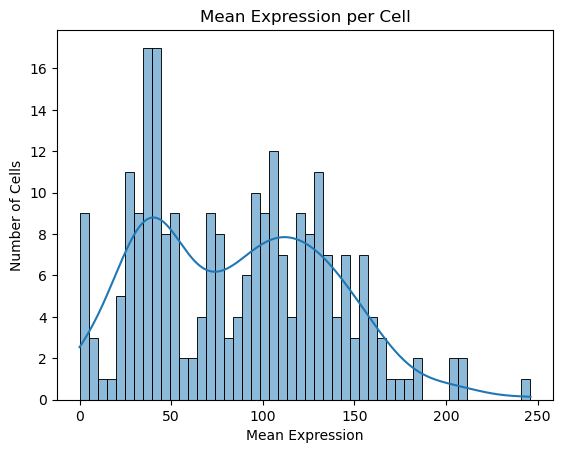

In [16]:
sns.histplot(cells_stats_mcf["Mean"], bins=50, kde=True)
plt.title("Mean Expression per Cell")
plt.xlabel("Mean Expression")
plt.ylabel("Number of Cells")
plt.show()

> **Note on Normalization and Log Transformation**  
> In this notebook, we applied normalization and log transformation to better visualize expression distributions and reduce skewness/kurtosis. This helped us define data-driven filtering thresholds.  

In this cell, we check whether there are any **duplicate cells columns** in the filtered SmartSeq dataset (`dfs_hcc_f1`).

Using `duplicated().any()`, we ask:
> "Are there any cells with identical expression values across all genes' expressions?"

A return value of `True` suggests that at least one cell is duplicated — which might indicate redundancy or data preprocessing artifacts. Detecting and potentially removing duplicates helps ensure data integrity and avoid model bias.

In [17]:
duplicates_exist = dfs_hcc_unfiltered.T.duplicated().any()
print("Any duplicate cells?", duplicates_exist)

if duplicates_exist:
    # Count how many genes are duplicated
    dup_count = dfs_hcc_unfiltered.T.duplicated().sum()
    print(f"Number of duplicated genes: {dup_count}")
    
    # Show the index (gene names) of duplicated rows
    duplicated_genes = dfs_hcc_unfiltered.T[dfs_hcc_unfiltered.T.duplicated()].index.tolist()
    print("Duplicated cell(s):", duplicated_genes)
else:
    print("No duplicate cells columns found.")

Any duplicate cells? False
No duplicate cells columns found.


### Sampling and Log-Transforming a Subset of SmartSeq Cells

In this cell, we randomly select a **subset of 10 cells** from the unfiltered SmartSeq dataset (`dfs_hcc_unfiltered`) using a fixed random seed for reproducibility.

This small subset is used for **visual inspection** of gene expression patterns.
Next, we apply a **log transformation** using `log(1 + x)` to:
- Compress the wide range of expression values;
- Reduce the impact of outliers;
- Make the distribution more suitable for visualization;

Finally, the dataset is **reshaped ("melted") into long format**, which is required by Seaborn for generating violin plots of gene expression across cells. The violin plot shows:
- The **full distribution** of expression levels for each cell across all genes,
- Internal lines indicating **quartiles** (25%, 50%, 75%),
- The **shape** of the distribution, helping identify skewness or bimodality.

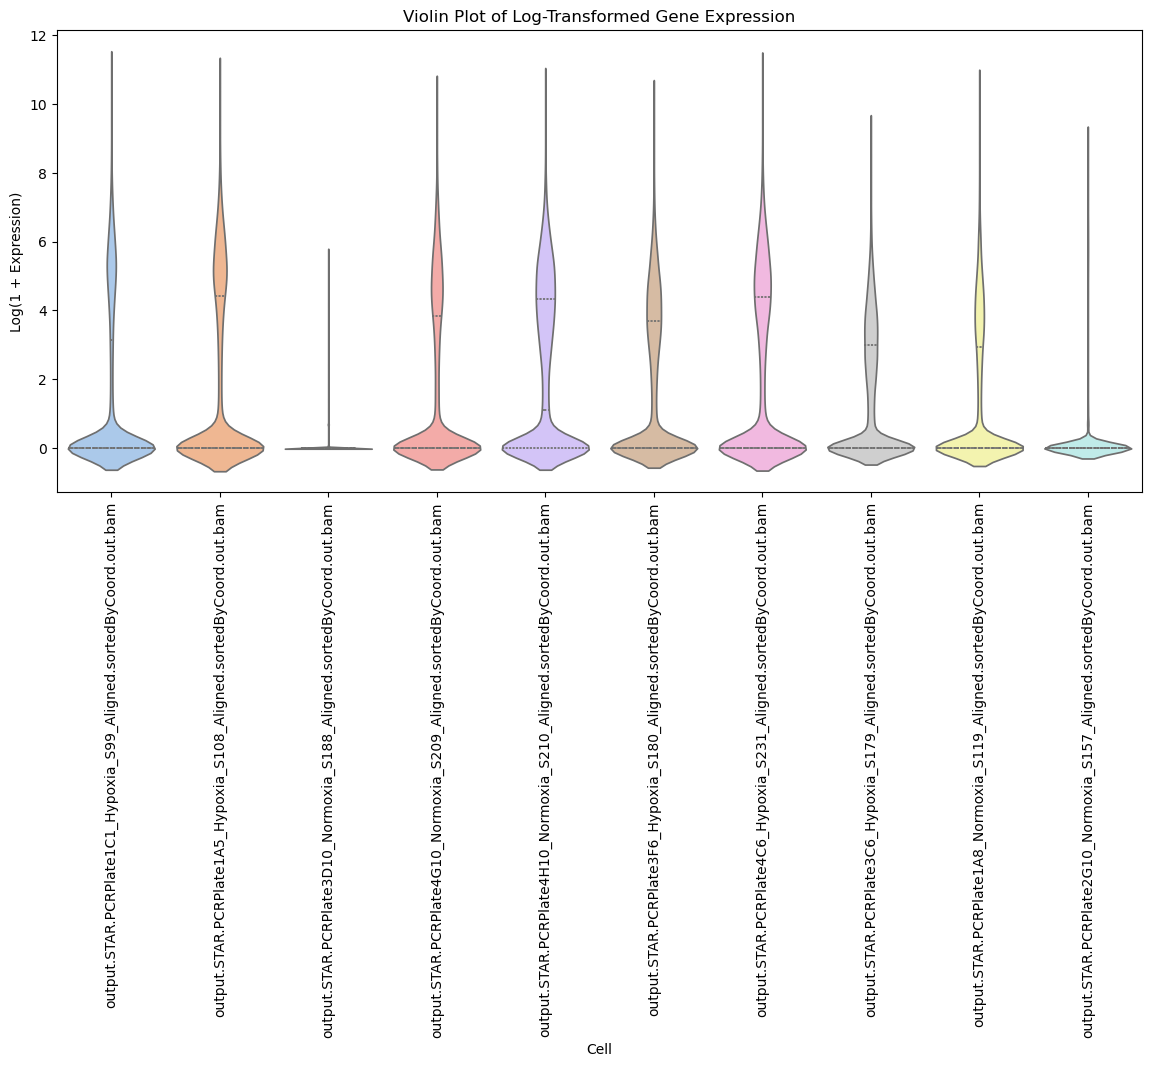

In [18]:
np.random.seed(42)  # per riproducibilità
subset_cells_mcf = np.random.choice(dfs_hcc_unfiltered.columns, size=10, replace=False)
dfs_hcc_subset = dfs_hcc_unfiltered[subset_cells_mcf]

# Log-transform: log(1 + x)
dfs_hcc_log = np.log1p(dfs_hcc_subset)

# Conversione in formato long per Seaborn
dfs_hcc_melted = dfs_hcc_log.melt(var_name="Cell", value_name="Log(1 + Expression)")

# Violin plot
plt.figure(figsize=(14, 6))
sns.violinplot(data=dfs_hcc_melted, x="Cell", y="Log(1 + Expression)", inner="quartile", density_norm="width", hue="Cell", palette="pastel")
plt.xticks(rotation=90)
plt.title("Violin Plot of Log-Transformed Gene Expression")
plt.show()

- Across virtually all ten cells, the bulk of “mass” sits near log‐expression = 0, indicating that most genes are essentially unexpressed (zero counts) in any given cell.  That sharp spike at zero is expected for single‐cell data, where each cell only expresses a few thousand genes out of the ~20 000 possible.
- Each violin has a long right‐hand tail (extending up to log‐expression ∼ 11–12). These tails reflect the handful of very highly expressed genes, even though we can see that their number is quite small.
- Using `log(1 + x)` makes mid-range expression differences visible.  

### Correlation analysis

We now compute the **correlation matrix** for the selected subset of cells. This matrix shows the **pairwise Pearson correlation coefficients** between the expression profiles of each pair of cells.

Correlation values close to 1 indicate highly similar gene expression patterns, while values near 0 (or negative) suggest little or inverse correlation.

By visualizing this matrix as a **heatmap**, we can visually assess how similar or different the randomly selected cells are. This helps us detect natural groupings, outliers, or unexpected variability within the dataset.


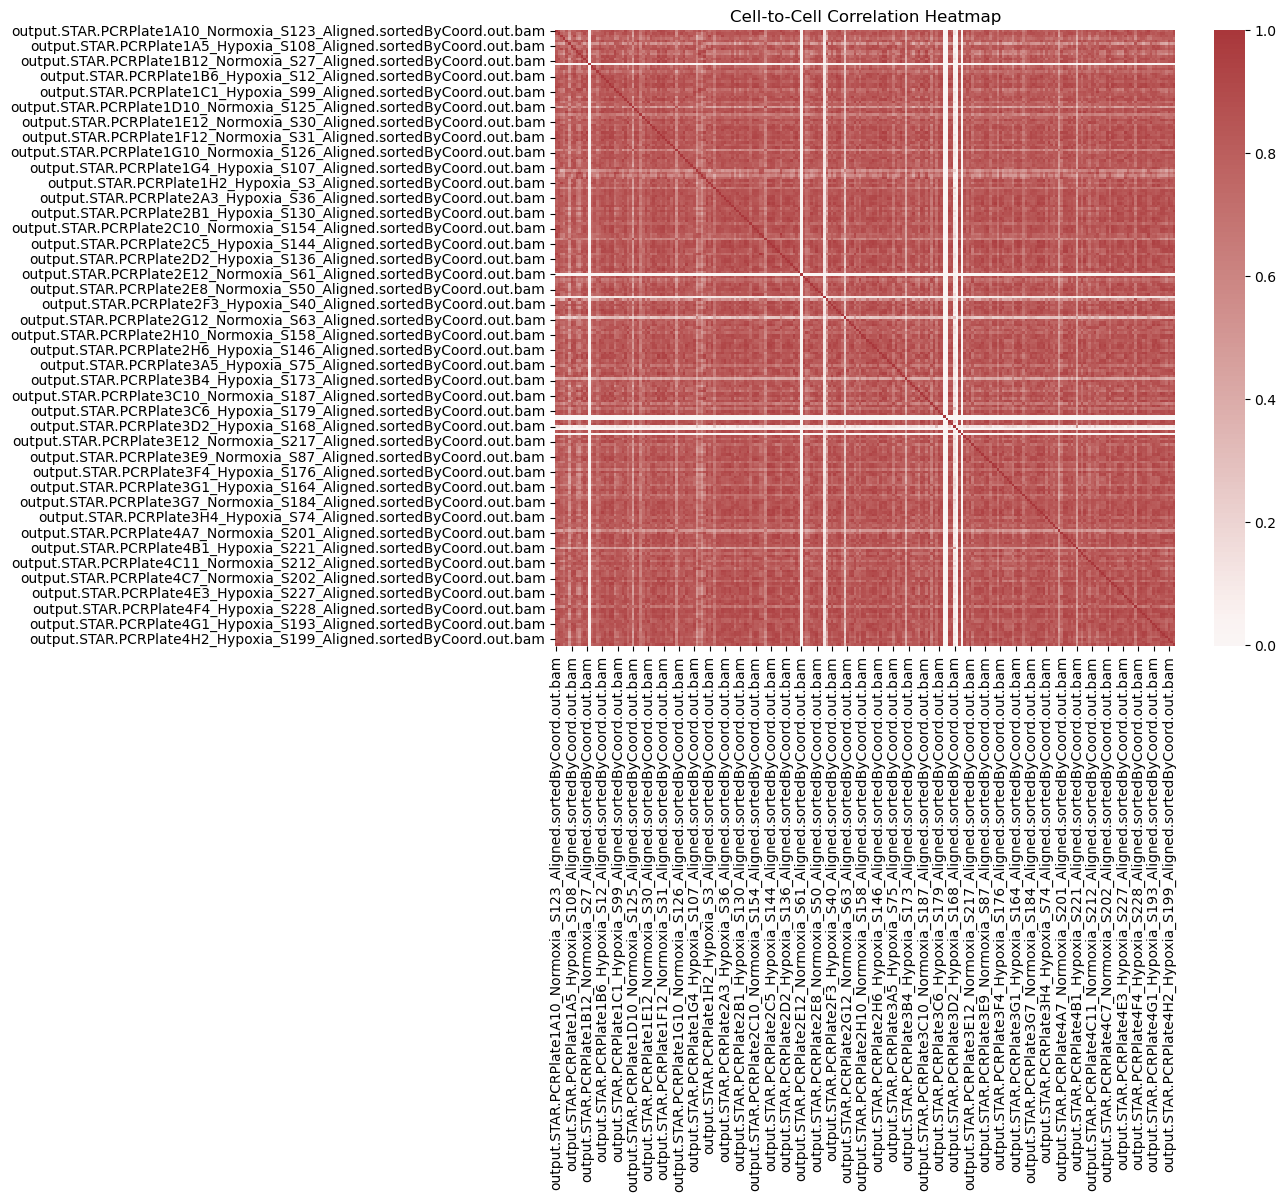

Feature pairs with |cov| > 0.8:
15990 

Feature pairs with |cov| > 0.9:
3154


In [19]:
# Compute correlation between cells (columns)
cell_corr_hcc = dfs_hcc_unfiltered.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cell_corr_hcc, cmap="vlag", center=0)
plt.title("Cell-to-Cell Correlation Heatmap")
plt.show()

high_corr = [
    (i, j, cell_corr_hcc.loc[i,j]) 
    for i in cell_corr_hcc.columns 
    for j in cell_corr_hcc.columns 
    if i < j and abs(cell_corr_hcc.loc[i,j]) > 0.8
]
print("Feature pairs with |cov| > 0.8:")
print(len(high_corr), "\n")

contr = 0
print("Feature pairs with |cov| > 0.9:")
for i,j,v in high_corr:
    if v >= 0.9:
            contr = contr + 1 
print(contr)


Asumming the reader alredy read the analysis regarding the mcf dataset, we will save a repetition of what high correlation means and why the Pearson correlation is not the best one to use in co-expression analysis. 

We are however happy to see that the number of very higly correlated expression is a third of the mcf dataset.

We now also check if a cell is a linear combinations of the others. This is very unlikely since we can see each cell as a 23396-dimensional vector and we have "only" 243 cells, but is still good habbit to check.

In [20]:
X = dfs_hcc_unfiltered.values

rank = np.linalg.matrix_rank(X)
print(f"Matrix rank = {rank} (out of {X.shape[1]} features)")

Q, R, piv = qr(X, mode='economic', pivoting=True)

indep_idx = piv[:rank]
dep_idx   = piv[rank:]

dependent_feats   = dfs_hcc_unfiltered.columns[dep_idx].tolist()

print("Dependent features (linear combos of the above):")
print(dependent_feats)

Matrix rank = 243 (out of 243 features)
Dependent features (linear combos of the above):
[]


As expected, no cell can be expressed as the linear combination of the others.

### Final visualization

To conclude the preliminary visualizitaion of how overall gene expression varies across individual cells, we select a **subset of 30 cells** from the SmartSeq HCC1806 dataset at random, but fixing the seed in the eventuality we want to do further analysis on the same set. We select just 30 cells for readability.

We apply a **log1p transformation** (`log(1 + expression)`) to reduce the effect of extreme values and improve interpretability. The expression values are then reshaped into long format for plotting.

A **boxplot** is used to show the distribution of expression levels **per cell**:
- The box shows the **interquartile range** (middle 50%),
- The line inside the box is the **median**,
- Whiskers and points indicate **spread and outliers**.


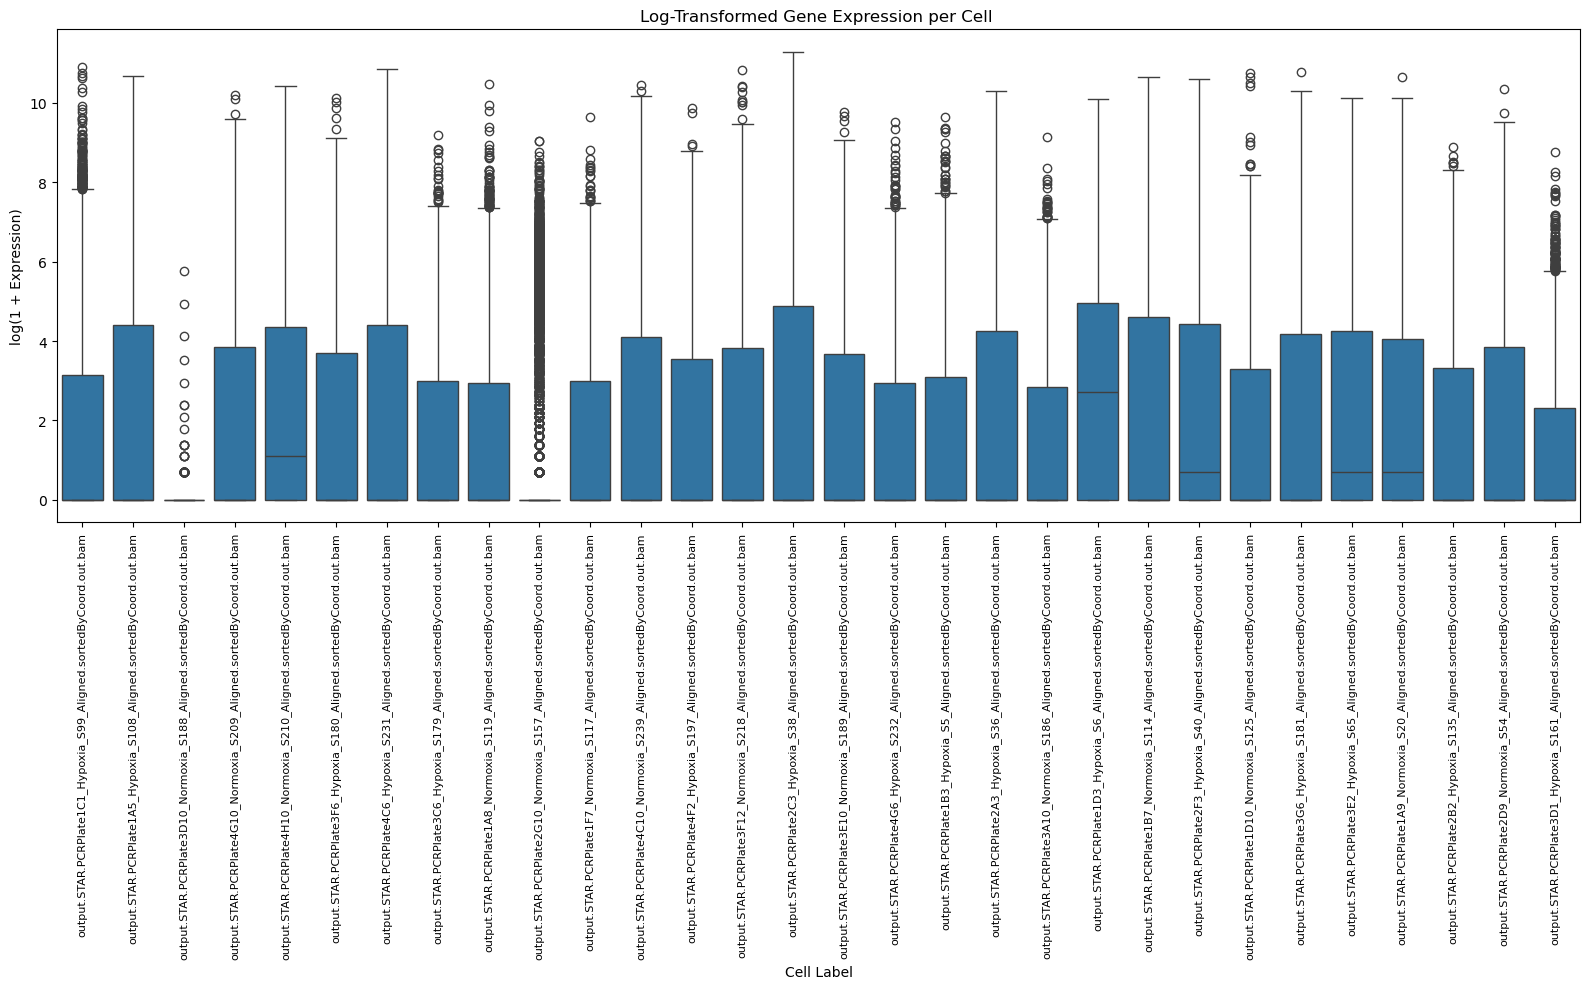

In [21]:
np.random.seed(42)  # for reproducibility
sampled_cells = np.random.choice(
    dfs_hcc_unfiltered.columns, 
    size=30, 
    replace=False
)

# Now subset:
dfs_hcc_subset = dfs_hcc_unfiltered[sampled_cells]

# Apply extraction
cell_labels = {name: name for name in sampled_cells}

# Apply log1p and rename columns using extracted labels
log_data = np.log1p(dfs_hcc_unfiltered[sampled_cells].rename(columns=cell_labels))

# Melt into long format
log_melted = log_data.melt(var_name="Cell", value_name="log(1 + Expression)")

# Plot
plt.figure(figsize=(16, 10))
sns.boxplot(x="Cell", y="log(1 + Expression)", data=log_melted, showfliers=True)
plt.title("Log-Transformed Gene Expression per Cell ")
plt.ylabel("log(1 + Expression)")
plt.xlabel("Cell Label")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

Although the median expression levels remain consistently balanced between 0 and 4, the distribution tails—represented by upper outliers capture biologically relevant variability. **These high-expression values likely reflect meaningful transcriptional activity in specific cell subpopulations**. Removing such outliers would obscure this variability and potentially eliminate informative patterns critical for downstream analysis. Therefore, retaining them is essential to preserve the full complexity of the dataset.

### **2.2** Per Gene
As we did for the per-cell perspective, we will dedicate the first cell of this section to compute basic descriptive statistics. The DataFrame `genes_stats_hcc` will summarize the same informations summarized in `cells_stats_hcc`, whith just a new parameter:
- `% Expressing`: percentage of cells for which the values of the expression of the gene is > 0. 

These values help assess the **complexity and quality of each single gene**.
A low value of the new statistic for a gene could indicate low relevance, noise, or technical dropout.


Only the **head** (first few rows) is printed for readability.

In [22]:
genes_stats_hcc = pd.DataFrame({
    'Mean': dfs_hcc_unfiltered.T.mean(),
    'Median': dfs_hcc_unfiltered.T.median(),
    'Std. dev.': dfs_hcc_unfiltered.T.std(),
    'Min': dfs_hcc_unfiltered.T.min(),
    'Max': dfs_hcc_unfiltered.T.max(),
    'Q1': dfs_hcc_unfiltered.T.quantile(0.25),
    'Q3': dfs_hcc_unfiltered.T.quantile(0.75),
    'Skewness': dfs_hcc_unfiltered.T.skew(),
    'Kurtosis': dfs_hcc_unfiltered.T.kurtosis(),
    '% Expressing': (dfs_hcc_unfiltered > 0).mean(axis=1) * 100
})

print("Per-gene statistics (HCC dataset):")
genes_stats_hcc.head()

Per-gene statistics (HCC dataset):


,Mean,Median,Std. dev.,Min,Max,Q1,Q3,Skewness,Kurtosis,% Expressing
WASH7P,0.045267,0.0,0.318195,0,3,0.0,0.0,7.973083,67.017076,2.469136
CICP27,0.119342,0.0,0.594531,0,5,0.0,0.0,6.145514,41.908461,5.349794
DDX11L17,0.469136,0.0,1.455282,0,12,0.0,0.0,4.668776,25.983103,17.695473
WASH9P,0.255144,0.0,0.818639,0,6,0.0,0.0,4.509780,23.781800,13.991770
OR4F29,0.127572,0.0,0.440910,0,4,0.0,0.0,4.690375,28.918590,9.876543


We will come back later on the results given by `gene_stats_hcc['% Expressing']`while analyzing sparsity.

To better understand the global activity levels of genes in the SmartSeq HCC1806 dataset, we compute the **log-transformed mean expression** for each gene.

The `log1p()` transformation is key for the same reasons it was for the cell perspective representation.

We then plot a histogram of these log-transformed values. The x-axis shows the log-mean expression level, and the y-axis shows how many genes fall into each expression range.

This kind of plot is useful for distinguishing:
- **Lowly expressed genes**, which may be uninformative or noisy,
- **Highly expressed genes**, which may play important roles in core cellular processes or specific cancer-related pathways.

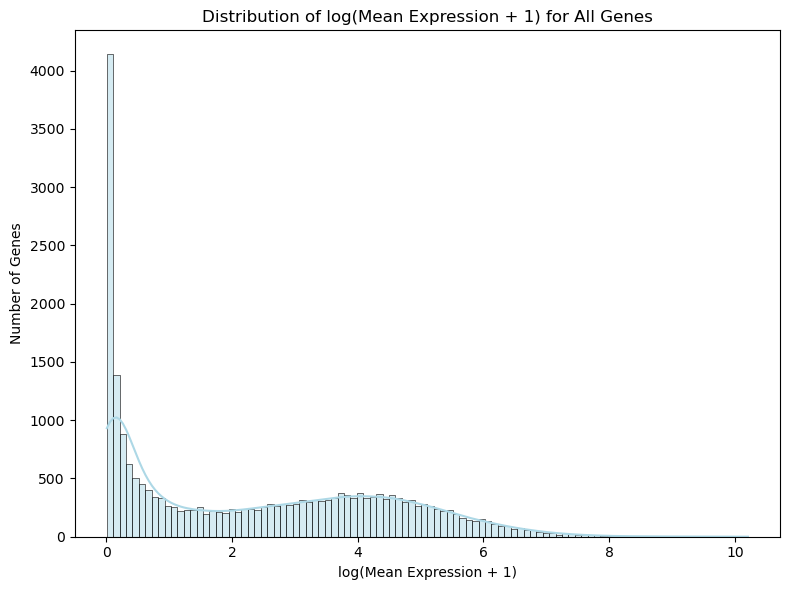

In [23]:
# Create a new column for log(Mean + 1)
genes_stats_hcc['logMean'] = np.log1p(genes_stats_hcc['Mean'])  # log1p(x) = log(x+1)

plt.figure(figsize=(8, 6))
sns.histplot(
    genes_stats_hcc['logMean'],
    bins=100,
    kde=True,
    color='lightblue'
)
plt.xlabel("log(Mean Expression + 1)")
plt.ylabel("Number of Genes")
plt.title("Distribution of log(Mean Expression + 1) for All Genes")
plt.tight_layout()
plt.show()

Most genes have **very low log–mean expression** (spike near 0), while a much smaller tail of genes shows higher expression, up to log8. This distribution helps identify lowly expressed (potentially noisy) genes versus highly expressed candidates for downstream analysis.  

To explore which genes are most active across the HCC1806 cell population, we visualize the **top 10 genes by average expression**.

For each gene, we plot:
- The **mean expression level** as a bar,
- The **standard deviation** as an error bar (indicating how much expression varies across cells),
- The **percentage of cells expressing the gene**, annotated above each bar.

This plot provides a concise overview of the genes that are consistently and strongly expressed, helping identify potential **housekeeping genes** or **biomarkers**. Genes with high expression but low variance are often functionally essential, while those with high variability may reflect cell state differences or regulation.


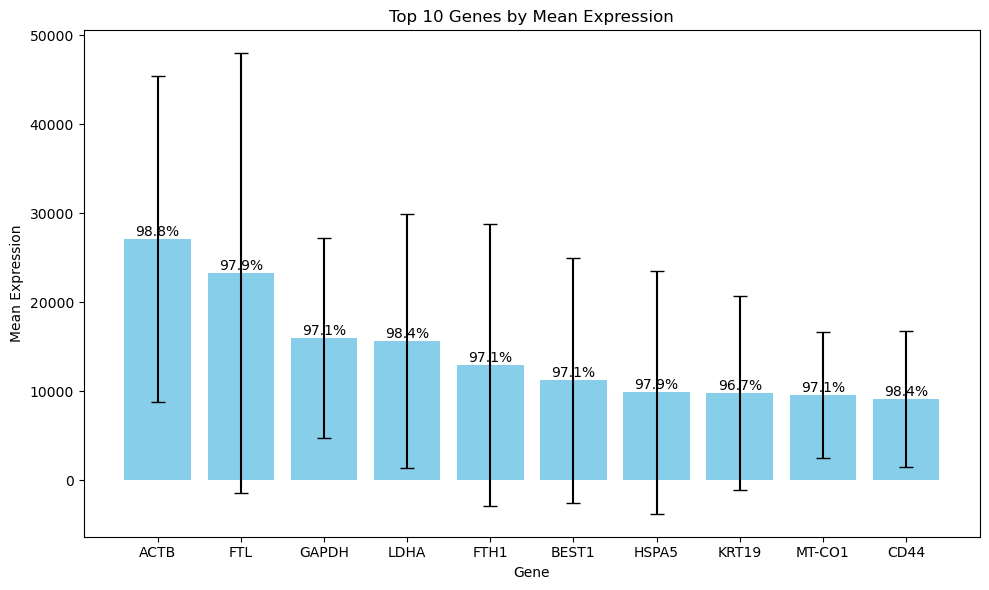

In [24]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

top10_genes_hcc = genes_stats_hcc.sort_values(by='Mean', ascending=False).head(10)

# Create a bar plot for the top 10 genes with error bars (SD)
bars = ax.bar(top10_genes_hcc.index, top10_genes_hcc['Mean'], yerr=top10_genes_hcc['Std. dev.'], capsize=5, color='skyblue')

ax.set_ylabel("Mean Expression")
ax.set_xlabel("Gene")
ax.set_title("Top 10 Genes by Mean Expression")

# Annotate each bar with the percentage of cells expressing the gene
for bar, pct in zip(bars, top10_genes_hcc["% Expressing"]):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

To better understand how expression varies across cells for the **top 10 most expressed genes**, we extract their expression values from the original unfiltered SmartSeq HCC1806 dataset.

After we **reshape the data into long format**, which is required by Seaborn’s `violinplot()` function, each row in the reshaped DataFrame corresponds to a single gene-cell expression value.

The violin plot shows the same features as in the per-cell case, just this time we look for the level of expression of each gene across al cells.

This visualization adds depth to the bar plot by revealing whether a gene is consistently expressed across cells or driven by a subset of highly expressing cells.


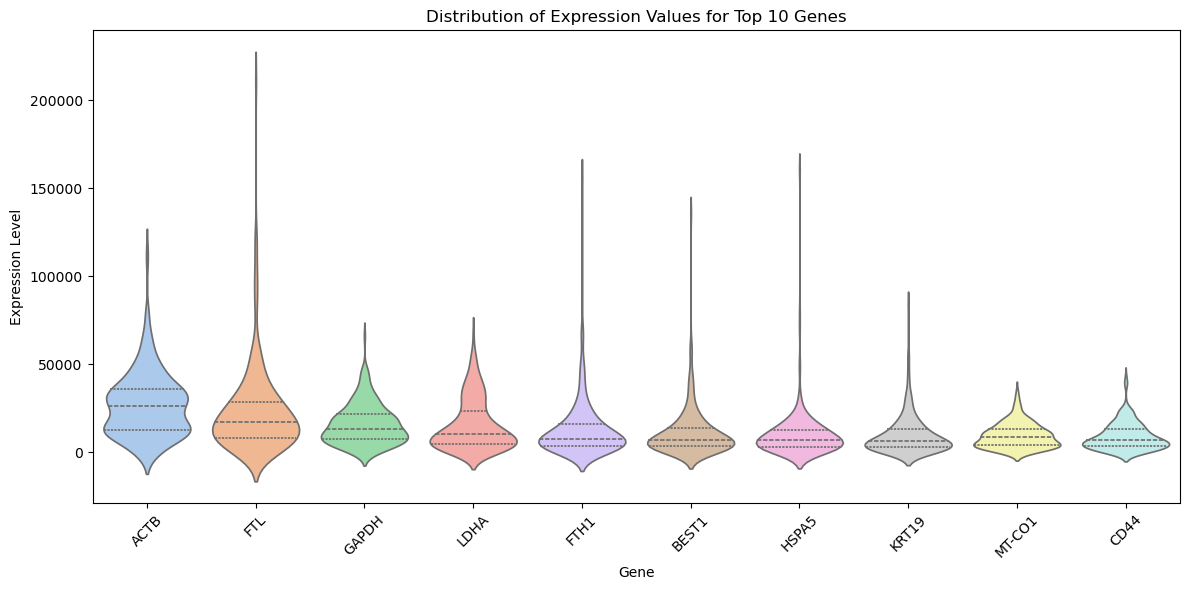

In [25]:
# Subset original data for only the top 10 genes
df_top10 = dfs_hcc_unfiltered.loc[top10_genes_hcc.index]

# Melt the DataFrame so that you have a long-form DataFrame for seaborn
df_melted = df_top10.reset_index().melt(id_vars='index', var_name='Cell', value_name='Expression')
df_melted.rename(columns={'index': 'Gene'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.violinplot(x='Gene', y='Expression', data=df_melted, inner='quartile', hue="Gene", palette='pastel')
plt.title("Distribution of Expression Values for Top 10 Genes")
plt.xlabel("Gene")
plt.ylabel("Expression Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**What this plot actually shows**  
- **X‐axis (Gene)**: Each of the ten top genes is its own category.  
- **Y‐axis (Expression Level)**: The raw count (non‐log) of how many transcripts of that gene were observed in each cell.  
- **Violin shape**:  
  - At any given Y‐value, the width of the violin is proportional to the estimated density (via a kernel density estimate) of cells whose expression for that gene equals that Y‐value.  
  - A wide “waist” around, say, **10 000** means many cells have expression ~10 000 for that gene.  
  - A thin “neck” at, say, **40 000** means very few cells reach that high count.  
- **lines**: dot lines represents the upper and lower quartile, while the line in between repressents the avarage<br>(be carefull that lower quartile distance seems greater than upper quartile distance from avarage but that's just due to the reductive scale)

## **3.** Sparsity
---

In single-cell RNA-seq data, sparsity refers to the high proportion of zero values in the gene expression matrix. This sparsity arises due to both **biological reasons** (e.g., genes not expressed in certain cells) and **technical limitations** (e.g., dropout events during sequencing).

It is crucial to quantify and understand sparsity before performing any filtering or transformation, as naive methods (e.g., standard outlier removal) may eliminate informative, biologically meaningful values. For example, a gene expressed in only a few cells might represent a cell-type-specific marker or a response to hypoxic stress.

### Global Sparsity

In [26]:
n_genes, n_cells = dfs_hcc_unfiltered.shape
print(n_genes)
print(dfs_hcc_unfiltered.shape)
total_entries = n_genes * n_cells
total_zeros = (dfs_hcc_unfiltered == 0).sum().sum()
global_sparsity = total_zeros / total_entries
print(f"\n Global sparsity: {global_sparsity:.2%} ({total_zeros:,} / {total_entries:,} zero values)")

23396
(23396, 243)

 Global sparsity: 55.85% (3,174,951 / 5,685,228 zero values)


### Per Cell Sparsity

In [27]:
import math
# Sparsity per cell (columns): how many zeros per cell
cell_sparsity = (dfs_hcc_unfiltered == 0).sum(axis=0) / n_genes
print(f"\n Cell sparsity — mean: {cell_sparsity.mean():.2%}, std: {cell_sparsity.std():.2%}")
print(f"   Min: {cell_sparsity.min():.2%}") 
if cell_sparsity.max() == 1:
    print(f"Max: 100%")
else:
    max_sparsity = cell_sparsity.max()
    print(f"   Max: {math.floor(max_sparsity * 10000) / 100:.2f}%")


 Cell sparsity — mean: 55.85%, std: 9.66%
   Min: 40.22%
   Max: 99.85%


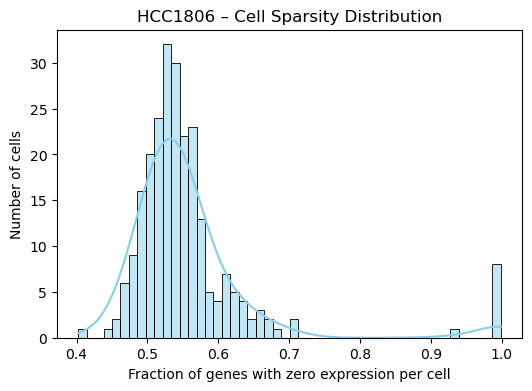

In [28]:
plt.figure(figsize=(6, 4))
sns.histplot(cell_sparsity, bins=50, kde=True, color="skyblue")
plt.title("HCC1806 – Cell Sparsity Distribution")
plt.xlabel("Fraction of genes with zero expression per cell")
plt.ylabel("Number of cells")
plt.show()

#### Per Gene Sparsity


In [29]:
gene_sparsity = (dfs_hcc_unfiltered == 0).sum(axis=1) / n_cells
print(f"\n Gene sparsity — mean: {gene_sparsity.mean():.2%}, std: {gene_sparsity.std():.2%}")
print(f"   Min: {gene_sparsity.min():.2%}, Max: {gene_sparsity.max():.2%}")


 Gene sparsity — mean: 55.85%, std: 37.30%
   Min: 1.23%, Max: 99.18%


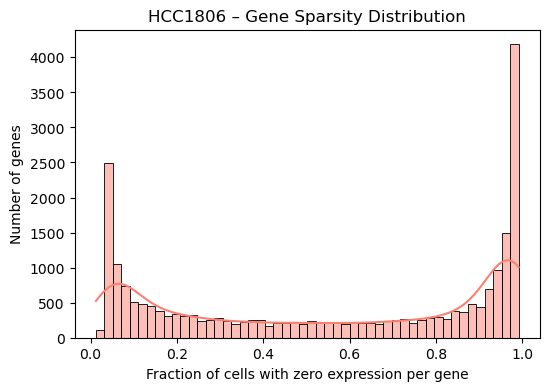

In [30]:
# Histogram: Gene sparsity
plt.figure(figsize=(6, 4))
sns.histplot(gene_sparsity, bins=50, kde=True, color="salmon")
plt.title("HCC1806 – Gene Sparsity Distribution")
plt.xlabel("Fraction of cells with zero expression per gene")
plt.ylabel("Number of genes")
plt.show()

#### Interpretation of Sparsity

- The **global sparsity** of the HCC1806 dataset is approximately **56%**, which is expected for Smart-seq single-cell data and suggests that dropout is present but not extreme.
- **Cell-level sparsity** ranges from 40% to 99%:
  - Most cells express a decent number of genes (30–50% non-zero entries).
  - A few cells have sparsity >90% or even 99.85%, which may indicate **low-quality cells or technical failure**.
- **Gene-level sparsity** displays a **bimodal distribution**:
  - A subset of genes are expressed in nearly all cells (likely core/housekeeping genes).
  - A large group of genes are expressed in only a few cells — some of these may be **biologically relevant** (e.g., markers), but many are likely **uninformative or noisy**.

> We therefore conclude that sparsity is not a problem **per se**, but should guide our filtering decisions.  
Outliers in this context may represent real biological variability (e.g., rare gene activation) and must not be removed blindly. Instead, we will filter based on **coverage-based thresholds** in the next section.

## **4.** Outlier Analysis
---

In classical data analysis, outliers — data points significantly different from the rest — are often removed to reduce noise or prevent distortion of statistical models.

However, in single-cell RNA-seq, **outliers may correspond to true biological signals**:
- A cell with exceptionally high expression of a stress-response gene may be undergoing apoptosis.
- A gene expressed in only a few cells might be a key transcription factor or rare marker.

Therefore, we need to **analyze outliers carefully**, especially at the **cell level**, where:
- Extremely low gene counts or total expression can indicate **low-quality cells**.
- Extremely high total counts might suggest **doublets** (two or more cells sequenced together).


In [31]:
# Total expression per cell (library size)
total_counts = dfs_hcc_unfiltered.sum(axis=0)
n_expressed_genes = (dfs_hcc_unfiltered > 0).sum(axis=0)

# Compute IQR-based thresholds
def get_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower, upper

# Thresholds
libsize_low, libsize_high = get_iqr_bounds(total_counts)
nexpr_low, nexpr_high = get_iqr_bounds(n_expressed_genes)

print(f"Total counts IQR: lower={libsize_low:.2f}, upper={libsize_high:.2f}")
print(f"Expressed genes IQR: lower={nexpr_low:.0f}, upper={nexpr_high:.0f}")

# Flagging outlier cells
low_libsize_cells = total_counts[total_counts < libsize_low]
high_libsize_cells = total_counts[total_counts > libsize_high]
low_gene_cells = n_expressed_genes[n_expressed_genes < nexpr_low]

print(f"Cells with low total expression: {len(low_libsize_cells)}")
print(f"Cells with high total expression (possible doublets): {len(high_libsize_cells)}")
print(f"Cells with very few expressed genes: {len(low_gene_cells)}")

Total counts IQR: lower=-1910116.00, upper=5826360.00
Expressed genes IQR: lower=8179, upper=13347
Cells with low total expression: 0
Cells with high total expression (possible doublets): 0
Cells with very few expressed genes: 18


#### Interpretation

While IQR-based methods are commonly used for outlier detection, they are **not effective in sparse, skewed data** like scRNA-seq:

- The IQR lower bound for total counts was negative, so **no cells were flagged as outliers**, despite known low-quality cells being present.
- This confirms that **IQR is too conservative** in this context and does not capture problematic cells.

Instead, we apply **data-aware filtering criteria** in the next section, using total counts, number of expressed genes, and sparsity thresholds.

## **5.** Filtering Strategy and Dataset Update
---

After characterizing sparsity and diagnosing outlier cells, we now define and apply a set of filtering rules to clean the dataset. These rules are based on biological and statistical reasoning, and are not arbitrary or heuristic-only.

#### Goals of filtering:
- Remove genes that are not informative (e.g., barely expressed across cells)
- Remove low-quality cells with too few expressed genes

We follow a two-part strategy:
1. **QC-based diagnostic thresholds** — exploratory histograms and metrics to understand data variability
2. **Final filtering logic** — using biologically and statistically motivated percentage-based thresholds

This strategy avoids overly aggressive or arbitrary cutoffs and maintains reproducibility, as emphasized in the project instructions.


### **5.1** QC Metrics
---

In [32]:
df1 = dfs_hcc_unfiltered.copy()

# Per-cell QC
cell_qc = pd.DataFrame({
    "total_counts": df1.sum(axis=0),
    "n_genes_by_counts": (df1 > 0).sum(axis=0),
    "pct_zero_genes": (df1 == 0).sum(axis=0) / df1.shape[0] * 100
})

# Per-gene QC
gene_qc = pd.DataFrame({
    "total_expression": df1.sum(axis=1),
    "pct_cells_expressed": (df1 > 0).sum(axis=1) / df1.shape[1] * 100
})
# Show stats
display(cell_qc.describe())
display(gene_qc.describe())

,total_counts,n_genes_by_counts,pct_zero_genes
count,2.430000e+02,243.000000,243.000000
mean,2.012306e+06,10330.358025,55.845623
std,1.171858e+06,2260.259356,9.660879
min,1.140000e+02,35.000000,40.220551
25%,9.910625e+05,10117.000000,51.235254
50%,2.067645e+06,10831.000000,53.705762
75%,2.925182e+06,11409.000000,56.757565
max,5.758132e+06,13986.000000,99.850402


,total_expression,pct_cells_expressed
count,2.339600e+04,23396.000000
mean,2.090060e+04,44.154377
std,1.024334e+05,37.300161
min,2.000000e+00,0.823045
25%,6.800000e+01,4.938272
50%,1.746500e+03,38.271605
75%,1.459825e+04,84.773663
max,6.582141e+06,98.765432


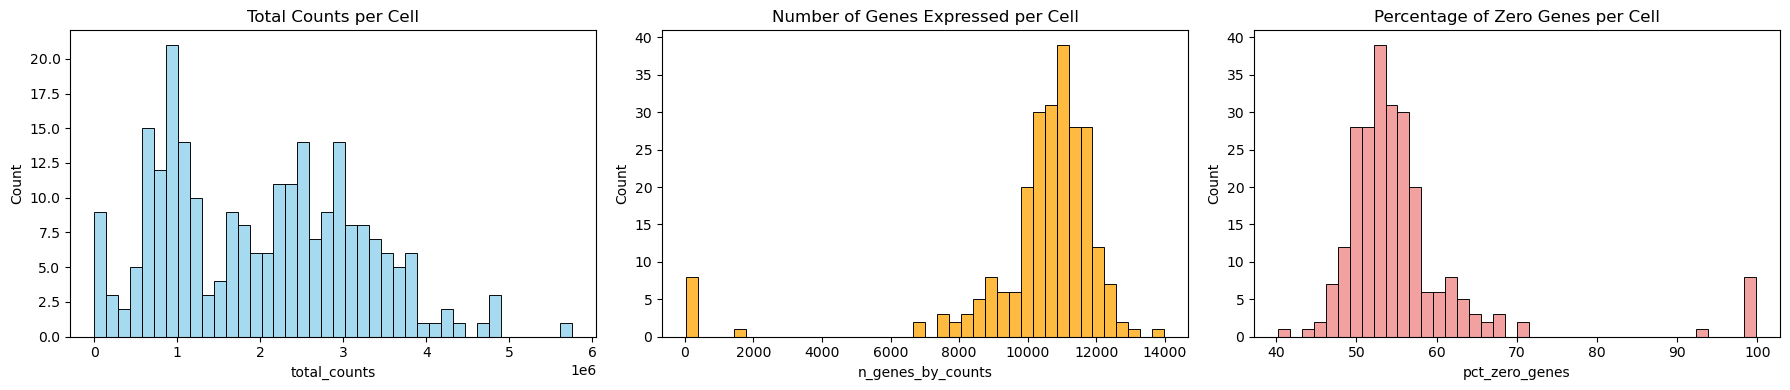

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(18, 4))

sns.histplot(cell_qc["total_counts"], bins=40, ax=axs[0], color="skyblue")
axs[0].set_title("Total Counts per Cell")

sns.histplot(cell_qc["n_genes_by_counts"], bins=40, ax=axs[1], color="orange")
axs[1].set_title("Number of Genes Expressed per Cell")

sns.histplot(cell_qc["pct_zero_genes"], bins=40, ax=axs[2], color="lightcoral")
axs[2].set_title("Percentage of Zero Genes per Cell")

plt.tight_layout()
plt.show()

#### Interpretation of QC Distributions

- **Total counts per cell** show a broad right-skewed distribution, with most cells between 0.5M and 3.5M counts, and a high peak around 1M. A small cluster near zero may correspond to low-quality or empty droplets.
- **Number of expressed genes** peaks around 11,000, with a small number of low or even zero-complexity cells. This justifies setting a cutoff around 6000 to exclude weak transcriptomes.
- **% of zero genes per cell** centers between 50–60%, which is biologically expected in Smart-seq. A few outlier cells at 100% clearly reflect failed captures.

> These metrics provide insight into cell quality and support our decision to avoid arbitrary hard cutoffs like 300k total counts or 7,000 genes.  
Instead, we proceed with a consistent and explainable filtering logic based on percentage coverage and gene complexity.

#### Interpretation (Exploratory Only)

- We examined per-cell total expression (`total_counts`), number of expressed genes, and sparsity.
- We can take more aggressive thresholds then mcf for `total_counts ≥ 500,000` since the difference in the distributions, `n_genes_by_counts ≥ 7,000`, or `pct_zeros ≤ 70%` might be **reasonable filters** as in mcf, but without formal derivation or literature backing, they are best used as diagnostics.
- At gene's level keeping genes `pct_cells_expressed ≥ 1` seems the most reasonable thing to do since we want to delete only very low quality genes, retaining as much as possible in this phase not having real biological foundations and risking to removing important ones. For the same reason we choose to retain genes with `total_expression ≥ 15`.
- Rather than relying on arbitrary cutoffs, we now proceed with percentage-based filtering grounded in reproducible logic.


### **5.2** Filtering Strategy
---

We apply two well-justified thresholds:

- **Gene-level:** Keep genes expressed in at least 2% of cells
- **Cell-level:** Keep cells expressing at least 3,500 genes

This approach balances sparsity reduction with biological signal retention and aligns with the target dimensions of the provided filtered dataset (18945 × 313).

In [34]:
# Filter cells
filtered_cells = cell_qc[
    (cell_qc["total_counts"] >= 500000) &
    (cell_qc["n_genes_by_counts"] >= 7000) &
    (cell_qc["pct_zero_genes"] <= 70)
]
df_cell_filtered = df1[filtered_cells.index]

# Filter genes
gene_qc_after = pd.DataFrame({
    "total_expression": df_cell_filtered.sum(axis=1),
    "n_cells_expressed": (df_cell_filtered > 0).sum(axis=1),
    "pct_cells_expressed": (df_cell_filtered > 0).sum(axis=1) / df_cell_filtered.shape[1] * 100
})
filtered_genes = gene_qc_after[
    (gene_qc_after["pct_cells_expressed"] >= 1) &
    (gene_qc_after["total_expression"] >= 15)
]
dfs_hcc_f1 = df_cell_filtered.loc[filtered_genes.index]

print(f"Final sparsity: {(dfs_hcc_f1 == 0).sum().sum() / dfs_hcc_f1.size:.2%}")

Final sparsity: 46.43%


In [35]:
dfs_hcc_f1.head()

,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A9_Normoxia_S20_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
CICP27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DDX11L17,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
WASH9P,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
OR4F29,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MTND1P23,250,424,63,27,81,305,82,46,177,114,...,205,113,47,27,35,146,37,83,47,249


### Comparison with the Filtered Dataset

To validate the effectiveness of our data-driven filtering, we compare our final filtered matrix with the reference dataset provided by the professor.

We check:
- The number of genes and cells retained
- The overlap in gene identifiers
- The final sparsity

A close match confirms that our strategy is well-aligned and appropriate for downstream analysis.

### Shape comparison

In [36]:
print("Final filtered shape:", dfs_hcc_f1.shape)
print("Reference shape:", dfs_hcc_filtered.shape)

Final filtered shape: (20011, 227)
Reference shape: (19503, 227)


### Compare gene sets

In [37]:
genes_final = set(dfs_hcc_f1.index)
genes_reference = set(dfs_hcc_filtered.index)

common_genes = genes_final.intersection(genes_reference)
only_in_final = genes_final - genes_reference
only_in_reference = genes_reference - genes_final

print(f"Genes in both sets: {len(common_genes)}")
print(f"Only in final filtered: {len(only_in_final)}")
print(f"Only in reference set: {len(only_in_reference)}")

Genes in both sets: 18874
Only in final filtered: 1137
Only in reference set: 629


### Compare cells sets

In [38]:
cells_final = set(dfs_hcc_f1.columns)
cells_reference = set(dfs_hcc_filtered.columns)

common_cells = cells_final.intersection(cells_reference)
only_in_final = cells_final - cells_reference
only_in_reference = cells_reference - cells_final

print(f"Cells in both sets: {len(common_cells)}")
print(f"Only in final filtered: {len(only_in_final)}")
print(f"Only in reference set: {len(only_in_reference)}")

Cells in both sets: 224
Only in final filtered: 3
Only in reference set: 3


We tested a more restrictive threshold of 7,000 genes per cell, which led to 230 retained cells — which is actually close to the reference (227) but at the cost of excluding potentially valid biological signal. We ultimately selected 6000 genes as a more conservative but biologically motivated threshold.

## **6.** Duplicates Check
---

To ensure the integrity of the dataset before normalization, we inspect the filtered matrix for duplicate entries.

We focus on two types:
- **Name duplicates**: rows or columns with the same name
- **Duplicate genes**: rows with the same gene expression, but different indexes

At this stage, we **do not remove duplicates**, but we list them and reflect on whether they require manual resolution.

In [39]:
# Start from your filtered matrix
df2 = dfs_hcc_f1  # already filtered by sparsity, not final log-transformed

In [40]:
df2.index.duplicated().any()

False

In [41]:
df2.columns.duplicated().any()

False

In [42]:
# Check for duplicate gene entries (row index)
duplicate_rows_mcf = df2.duplicated(keep=False)
df2[duplicate_rows_mcf]

,output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A5_Hypoxia_S108_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A6_Hypoxia_S11_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A7_Normoxia_S113_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A8_Normoxia_S119_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate1A9_Normoxia_S20_Aligned.sortedByCoord.out.bam,...,output.STAR.PCRPlate4G12_Normoxia_S243_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G1_Hypoxia_S193_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G2_Hypoxia_S198_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G6_Hypoxia_S232_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4G7_Normoxia_S204_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H10_Normoxia_S210_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H11_Normoxia_S214_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H2_Hypoxia_S199_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H7_Normoxia_S205_Aligned.sortedByCoord.out.bam,output.STAR.PCRPlate4H9_Normoxia_S236_Aligned.sortedByCoord.out.bam
PCDHA2,0,0,0,0,2,0,6,0,0,0,...,0,0,6,0,0,37,1,12,0,0
PCDHA4,0,0,0,0,2,0,6,0,0,0,...,0,0,6,0,0,37,1,12,0,0
PCDHA8,0,0,0,0,2,0,6,0,0,0,...,0,0,6,0,0,37,1,12,0,0
PCDHGA2,0,106,112,12,0,0,0,0,0,14,...,13,47,18,9,16,19,0,6,17,25
PCDHGA3,0,106,112,12,0,0,0,0,0,14,...,13,47,18,9,16,19,0,6,17,25
PCDHGB3,0,106,112,12,0,0,0,0,0,14,...,13,47,18,9,16,19,0,6,17,25
PCDHGA7,0,106,112,12,0,0,0,0,0,14,...,13,47,18,9,16,19,0,6,17,25
PCDHGA9,0,106,112,12,0,0,0,0,0,14,...,13,47,18,9,16,19,0,6,17,25
PCDHGB7,0,106,112,12,0,0,0,0,0,14,...,13,47,18,9,16,19,0,6,17,25
PCDHGA12,0,106,112,12,0,0,0,0,0,14,...,13,47,18,9,16,19,0,6,17,25


In [43]:
duplicates_grouped_hcc = df2.groupby(list(df2.columns)).filter(lambda x: len(x) > 1)
# Raggruppa nuovamente per profilo e costruisci le tuple con i nomi dei geni
duplicate_gene_hcc_tuples = [
    tuple(group.index)
    for _, group in duplicates_grouped_hcc.groupby(list(duplicates_grouped_hcc.columns))
]

# Stampa la lista di tuple
print("Duplicate gene tuples:", duplicate_gene_hcc_tuples)

Duplicate gene tuples: [('MIR3074', 'MIR24-1'), ('CCL3L3', 'CCL3L1'), ('MIR374B', 'MIR374C'), ('SUGT1P4-STRA6LP', 'STRA6LP'), ('MIR548AA1', 'MIR548D1'), ('PCDHA2', 'PCDHA4', 'PCDHA8'), ('PCDHGA2', 'PCDHGA3', 'PCDHGB3', 'PCDHGA7', 'PCDHGA9', 'PCDHGB7', 'PCDHGA12', 'PCDHGC4'), ('PANDAR', 'LAP3P2')]


- These are likely either:
  - Members of gene families 
  - Pseudogenes or read-through transcripts
  - Different transcript annotations at the same locus

We retain all of them for now, as they may carry **distinct biological signal**. 

## **7.** Normalization
---

In raw Smart-seq data, each cell can have a very different total read depth (i.e., total counts). These differences may result from:
- Variation in sequencing depth
- Cell size and RNA content
- Technical effects during library preparation

If we don't normalize, we cannot compare gene expression **between cells**, as some will appear to have more expression simply due to technical reasons.

Therefore, we normalize to:
- Make expression levels **comparable across cells**
- Remove technical variability related to sequencing depth
- Preserve the **biological structure** of the data

In [44]:
# Work on the filtered dataset
df3 = dfs_hcc_f1.copy() 

# Compute total counts per cell
library_sizes = df3.sum(axis=0)

# Normalize each cell to sum to 10,000
dfs_hcc_norm = df3.div(library_sizes) * 1e4

print("Normalization complete.")
print(f"After normalization, total counts per cell (first 5):\n{dfs_hcc_norm.sum(axis=0).head()}")

Normalization complete.
After normalization, total counts per cell (first 5):
output.STAR.PCRPlate1A10_Normoxia_S123_Aligned.sortedByCoord.out.bam    10000.0
output.STAR.PCRPlate1A12_Normoxia_S26_Aligned.sortedByCoord.out.bam     10000.0
output.STAR.PCRPlate1A2_Hypoxia_S104_Aligned.sortedByCoord.out.bam      10000.0
output.STAR.PCRPlate1A3_Hypoxia_S4_Aligned.sortedByCoord.out.bam        10000.0
output.STAR.PCRPlate1A4_Hypoxia_S8_Aligned.sortedByCoord.out.bam        10000.0
dtype: float64


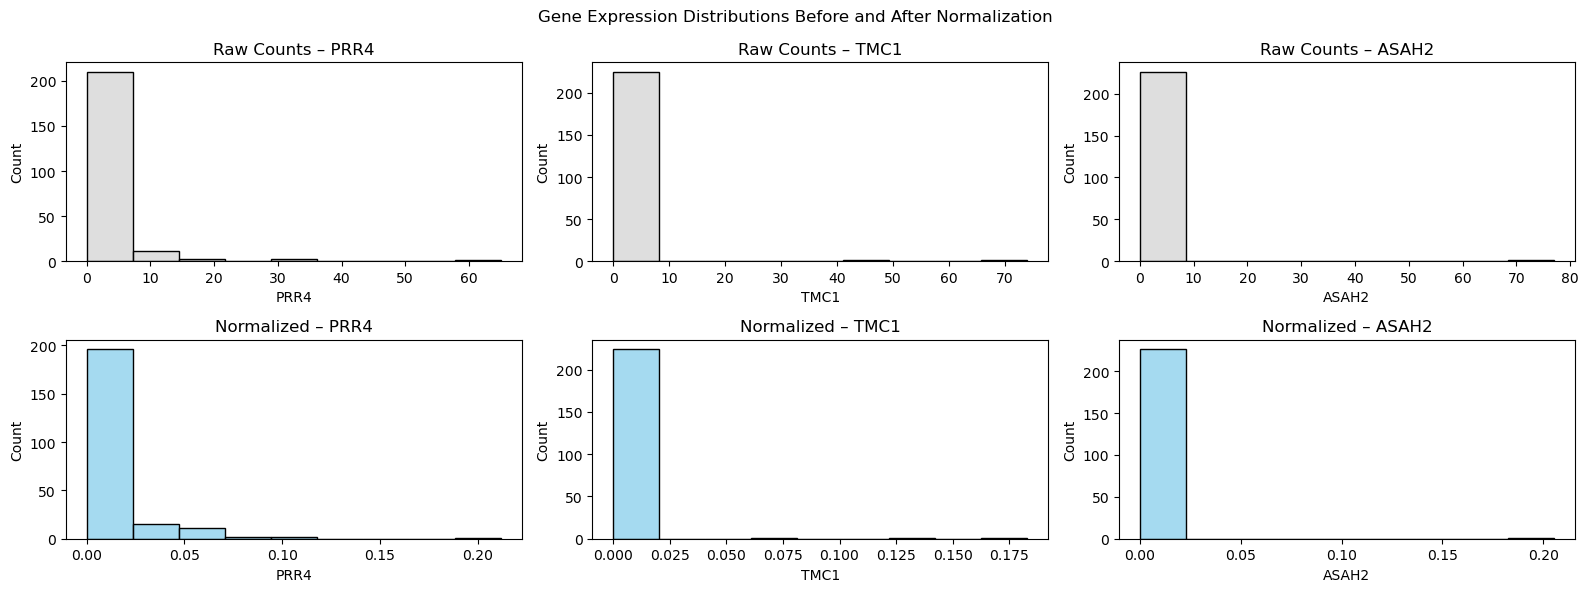

In [45]:
# Select a few random genes to compare distributions
sample_genes = df3.sample(n=3).index

fig, axs = plt.subplots(2, 3, figsize=(16, 6))
for i, gene in enumerate(sample_genes):
    sns.histplot(df3.loc[gene], ax=axs[0, i], color="lightgrey")
    axs[0, i].set_title(f"Raw Counts – {gene}")
    sns.histplot(dfs_hcc_norm.loc[gene], ax=axs[1, i], color="skyblue")
    axs[1, i].set_title(f"Normalized – {gene}")

plt.suptitle("Gene Expression Distributions Before and After Normalization")
plt.tight_layout()
plt.show()

To understand how normalization affects gene expression values, we compare the **raw counts** and **normalized values** for three example genes.

Each subplot shows a histogram of expression values across all cells for a single gene:
- The **top row** shows the distribution of **raw counts**, which are typically right-skewed and span a wide dynamic range.
- The **bottom row** shows the same genes after **normalization**, where values are scaled.

This side-by-side comparison highlights the effect of normalization:
- It compresses extreme values;
- Makes distributions more comparable across genes and cells;
- Prepares the data for algorithms that assume similar scales or variances.

Such normalization is essential before applying techniques like PCA, clustering, or classification.


## **8.** Distribution Diagnostic and Log-Transformation
---

Even after normalization, gene expression data in single-cell RNA-seq is often:
- **Highly skewed** (e.g. rare expression bursts in few cells)
- **Heavy-tailed** (high kurtosis due to dropouts or outliers)

These issues violate the assumptions of many statistical methods (e.g. PCA, linear models).  
We thus evaluate **per-gene skewness and kurtosis** and apply a **log1p transformation** to reduce these effects.

In [46]:
skewness1 = dfs_hcc_unfiltered.apply(skew, axis=1)
kurt1 = dfs_hcc_unfiltered.apply(kurtosis, axis=1)

dfs_hcc_log = np.log1p(dfs_hcc_norm)

skewness2 = dfs_hcc_log.apply(skew, axis=1)
kurt2 = dfs_hcc_log.apply(kurtosis, axis=1)

# Create summary DataFrame
dist_summary_mcf = pd.DataFrame({
    "Skewness pre": skewness1,
    "Kurtosis pre": kurt1,
    "Skewness after": skewness2,
    "Kurtosis after": kurt2
})

# Identify genes with high skewness or kurtosis
high_skew = dist_summary_mcf[abs(dist_summary_mcf["Skewness pre"]) > 2]
high_kurt = dist_summary_mcf[dist_summary_mcf["Kurtosis pre"] > 3]

high_skew2 = dist_summary_mcf[abs(dist_summary_mcf["Skewness after"]) > 2]
high_kurt2 = dist_summary_mcf[dist_summary_mcf["Kurtosis after"] > 3]

print("Pre:")
print(f"Genes with skewness > {2}: {len(high_skew)}")
print(f"Genes with kurtosis > {3}: {len(high_kurt)}")

print("After:")
print(f"Genes with skewness > {2}: {len(high_skew2)}")
print(f"Genes with kurtosis > {3}: {len(high_kurt2)}")

dist_summary_mcf.head()

Pre:
Genes with skewness > 2: 19165
Genes with kurtosis > 3: 21299
After:
Genes with skewness > 2: 9412
Genes with kurtosis > 3: 10759


,Skewness pre,Kurtosis pre,Skewness after,Kurtosis after
A1BG,4.110408,23.706533,1.296760,2.393802
A1BG-AS1,2.923891,12.780931,0.742528,0.551805
A1CF,10.521247,115.181280,9.445035,92.452282
A2M,10.466445,116.734537,NaN,NaN
A2M-AS1,14.374404,214.133453,11.378816,144.249694


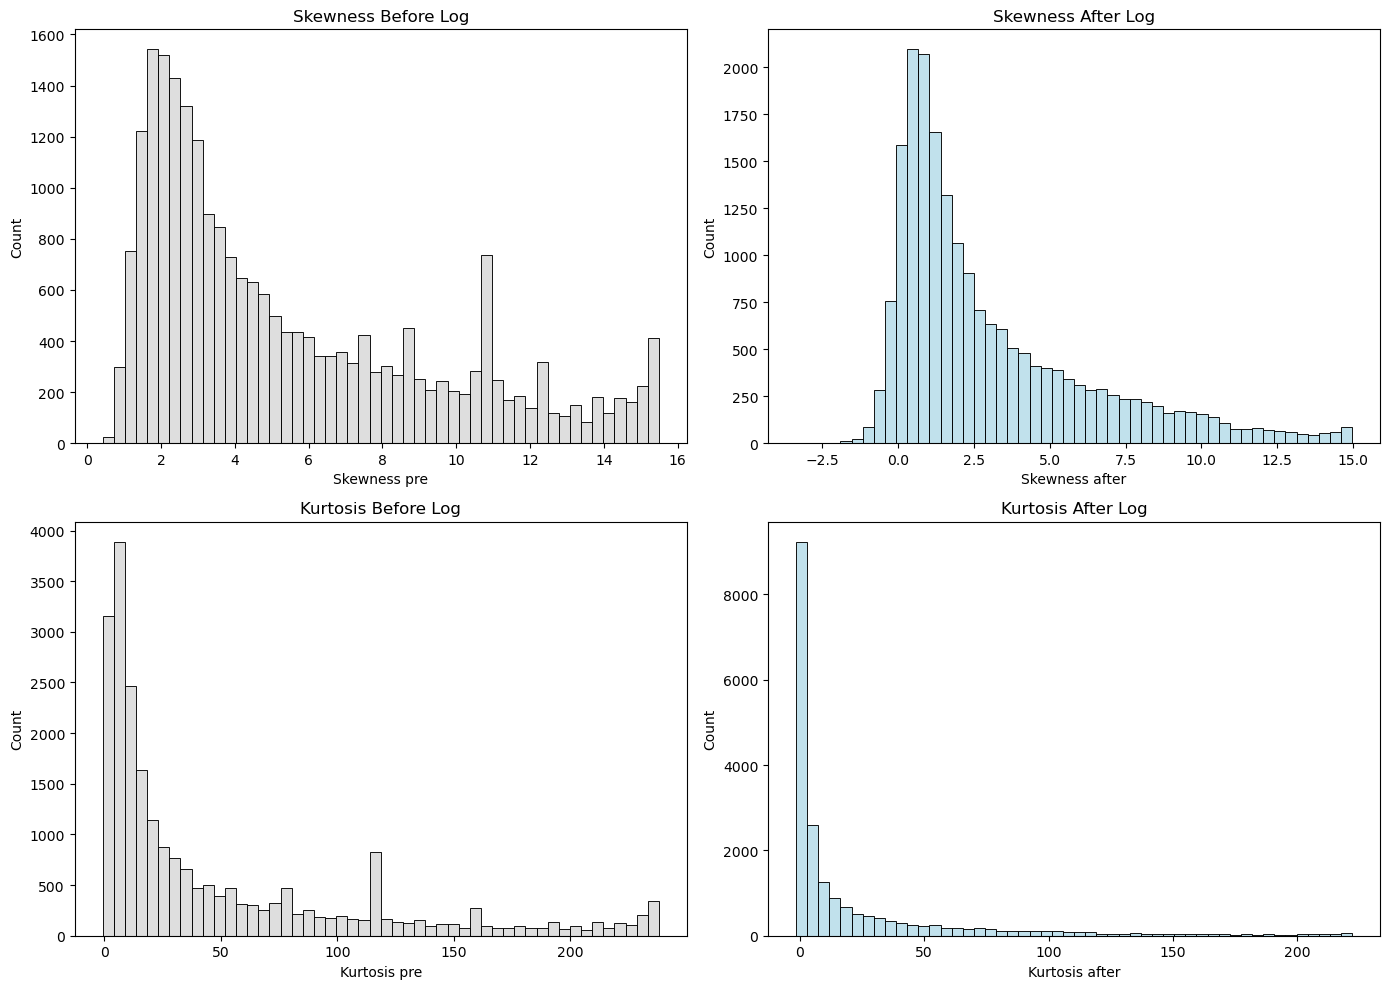

In [47]:

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(dist_summary_mcf["Skewness pre"], bins=50, color="lightgrey", ax=axs[0, 0])
axs[0, 0].set_title("Skewness Before Log")

sns.histplot(dist_summary_mcf["Skewness after"], bins=50, color="lightblue", ax=axs[0, 1])
axs[0, 1].set_title("Skewness After Log")

sns.histplot(dist_summary_mcf["Kurtosis pre"], bins=50, color="lightgrey", ax=axs[1, 0])
axs[1, 0].set_title("Kurtosis Before Log")

sns.histplot(dist_summary_mcf["Kurtosis after"], bins=50, color="lightblue", ax=axs[1, 1])
axs[1, 1].set_title("Kurtosis After Log")

plt.tight_layout()
plt.show()

#### Interpretation
- A large number of genes show high skewness and kurtosis before log-transformation, reflecting sparse expression and outlier events.
- After `log1p`, both skewness and kurtosis are reduced across most genes, though some remain highly skewed, especially if expressed in very few cells.

This transformation stabilizes variance, compresses long right tails, and improves the overall statistical behavior of the data, making it more suitable for downstream dimensionality reduction and modeling.

In [48]:
# Flatten all normalized values into one 1-D array
raw_vals = dfs_hcc_norm.values.ravel()

# Compute the 7 summary statistics
summary_raw = pd.Series({
    "mean": np.mean(raw_vals),
    "std":  np.std(raw_vals, ddof=1),
    "min":  np.min(raw_vals),
    "25%":  np.percentile(raw_vals, 25),
    "50%":  np.percentile(raw_vals, 50),
    "75%":  np.percentile(raw_vals, 75),
    "max":  np.max(raw_vals),
}, name="Raw")

# Display as a one-row DataFrame
display(summary_raw.to_frame().T.round(4))

,mean,std,min,25%,50%,75%,max
Raw,0.4997,2.5967,0.0,0.0,0.0114,0.3506,521.842


In [49]:
# Flatten all log1p’d values into one 1-D array
log_vals = np.log1p(dfs_hcc_norm.values).ravel()

# Compute the same 7 statistics
summary_log = pd.Series({
    "mean": np.mean(log_vals),
    "std":  np.std(log_vals, ddof=1),
    "min":  np.min(log_vals),
    "25%":  np.percentile(log_vals, 25),
    "50%":  np.percentile(log_vals, 50),
    "75%":  np.percentile(log_vals, 75),
    "max":  np.max(log_vals),
}, name="Norm&Log")

# Display as a one-row DataFrame
display(summary_log.to_frame().T.round(4))

,mean,std,min,25%,50%,75%,max
Norm&Log,0.2359,0.432,0.0,0.0,0.0114,0.3006,6.2593


### Summary Statistics Interpretation after computing normalization and log-transformation

We computed per-cell summary statistics before and after `log1p` transformation to assess how the distribution of gene expression values changed.

Here’s what we observed:

| Metric     | Before Log | After Log | Interpretation |
|------------|------------|-----------|----------------|
| **mean**   | ~0.499      | ↓ ~0.236   | Expression values are compressed, reducing average magnitude |
| **std**    | ~2.60  | ↓ ~0.43| Log-transformation stabilized variance across cells |
| **max**    | ~521.8   | ↓ ~6.26| Long right tails compressed into interpretable ranges |
| **median** | 0 or close to 0 | unchanged | Log preserves 0s (since `log1p(0) = 0`), keeping sparsity structure |

Most cells had **extremely right-skewed gene distributions** in the normalized matrix, with very high max values and wide variance. After log1p:
- The **scale is compressed**
- The **spread is more controlled**
- The data becomes more statistically tractable, especially for linear models like PCA

> While the data is still sparse and not perfectly Gaussian, these transformations make the distribution *closer* to normal and reduce the influence of extreme outliers. This is essential for downstream dimensionality reduction and clustering tasks.

## **9.** High Variable Gene Selection
---

Single-cell RNA-seq data typically includes thousands of genes, but only a subset are truly informative. Many genes are either:

- Not expressed in most cells
- Uniformly expressed (low variability)
- Dominated by technical noise

To reduce dimensionality and focus on biological signal, we select the **top 3,000 most variable genes** after normalization and `log1p` transformation.

To better approximate the professor’s filtered dataset, we now adopt a more biologically-informed approach based on **normalized dispersion**, similar to what is done in Seurat and Scanpy.

**Why not raw variance?**
- Genes with high mean expression also have high variance by construction
- We want genes with **unusually high variance relative to their mean**

**Steps:**
1. Compute mean and variance per gene (after log-normalization)
2. Calculate dispersion = variance / mean
3. Normalize dispersion within expression bins
4. Select the top 3,000 genes with highest normalized dispersion

This method better detects genes with true biological variability.


In [50]:
# Start from log-normalized matrix
df4 = dfs_hcc_log.copy()

# Step 1: Mean and variance per gene
mean = df4.mean(axis=1)
var = df4.var(axis=1)
dispersion = var / mean

# Step 2: Filter out low-expressed genes (optional, improves stability)
min_cells = int(df4.shape[1] * 0.01)
expressed_genes = (df4 > 0).sum(axis=1) >= min_cells
df4 = df4.loc[expressed_genes]
mean = mean.loc[expressed_genes]
dispersion = dispersion.loc[expressed_genes]

# Step 3: Bin genes by mean expression
bin_count = 20
bins = pd.qcut(mean, q=bin_count, duplicates='drop')
disp_df = pd.DataFrame({
    'mean': mean,
    'dispersion': dispersion,
    'bin': bins
})

# Step 4: Normalize dispersion within bins
disp_df['norm_dispersion'] = disp_df.groupby('bin', observed=False)['dispersion'].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Step 5: Select top 3000 HVGs by normalized dispersion
top_dispersion_genes = disp_df.sort_values("norm_dispersion", ascending=False).head(3000)
dfs_mcf_hvg = dfs_hcc_log.loc[top_dispersion_genes.index]

print(f"Dispersion-based HVG matrix shape: {dfs_mcf_hvg.shape}")

Dispersion-based HVG matrix shape: (3000, 227)


To further refine our selection of highly variable genes, we apply a **decorrelation step** to remove redundancy and improve feature diversity.

While the top 3,000 genes based on normalized dispersion are individually informative, many of them may be **highly correlated with each other** (e.g., co-regulated genes or duplicated sequences). This can introduce bias and redundancy in downstream analyses like PCA or classification.

The procedure is as follows:

1. **Start with the top 5,000 HVGs** (instead of 3,000) to allow flexibility in removing duplicates.
2. Compute the **absolute correlation matrix** between these genes, based on their log-normalized expression values.
3. Apply a **greedy decorrelation algorithm**:
   - Iterate through the genes in ranked order.
   - Keep the current gene only if it is not **highly correlated** (correlation > 0.95) with a gene already selected.
   - Exclude all of its highly correlated partners from further consideration.
   - Repeat until 3,000 non-redundant genes are selected.

This process ensures that the final gene set is both **informative and diverse**, improving robustness and interpretability of downstream models.

The resulting matrix (`dfs_hcc_hvg2`) contains 3,000 decorrelated HVGs and is ready for dimensionality reduction or supervised modeling.

In [51]:
# Step 0: Start with your dispersion-based HVG list (sorted)
disp_df_sorted = disp_df.sort_values("norm_dispersion", ascending=False)
candidate_genes = disp_df_sorted.index.tolist()

# Safety: take more than 3000 to allow for replacements
buffer = 5000
buffered_genes = candidate_genes[:buffer]

# Step 1: Build correlation matrix from top genes
df_corr_source = dfs_hcc_log.loc[buffered_genes]
corr_matrix = df_corr_source.T.corr().abs()

# Step 2: Greedy decorrelation (keep top-ranked genes)
selected = []
excluded = set()
threshold = 0.95

for gene in buffered_genes:
    if gene in excluded:
        continue
    selected.append(gene)
    # Exclude highly correlated genes (lower ranked)
    high_corr = corr_matrix.loc[gene][corr_matrix.loc[gene] > threshold].index
    excluded.update(set(high_corr))

    if len(selected) == 3000:
        break

# Step 3: Final dataset
dfs_hcc_hvg2 = dfs_hcc_log.loc[selected]
print(f"Decorrelated HVG matrix shape: {dfs_hcc_hvg2.shape}")

Decorrelated HVG matrix shape: (3000, 227)


In [52]:
# Use log-transformed and possibly z-scored data (choose depending on your current state)
df_corr_input = dfs_hcc_hvg2  # or df_zscore if you already did z-scoring

# Compute pairwise gene-gene correlation
# Transpose so rows are samples, columns are genes
gene_corr = df_corr_input.T.corr(method='pearson')

# Find highly correlated gene pairs (upper triangle only)
threshold = 0.95
upper_tri = gene_corr.where(np.triu(np.ones(gene_corr.shape), k=1).astype(bool))

# Identify strongly correlated pairs
high_corr_pairs = upper_tri.stack().reset_index()
high_corr_pairs.columns = ['Gene1', 'Gene2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'].abs() > threshold]

print(f"Highly correlated gene pairs found: {len(high_corr_pairs)}")

Highly correlated gene pairs found: 0


To validate our highly variable gene (HVG) selection, we compare our final gene list (`dfs_hcc_hvg2`) against the one used in the professor’s reference dataset (`dfs_hcc_train`).

By computing the **intersection of the gene sets**, we determine how many of our selected HVGs overlap with the professor's version.

A **high degree of overlap** suggests that our method is aligned with the professor’s preprocessing choices, indicating that:
- Our dispersion-based and decorrelated HVG selection is biologically sound,
- The downstream analyses built on this gene set will be comparable and consistent with the reference pipeline.

This step acts as a quick **sanity check** to verify reproducibility and methodological agreement.


In [53]:
professor_genes = set(dfs_hcc_train.index)
our_genes = set(dfs_mcf_hvg.index)

common = professor_genes.intersection(our_genes)
print(f"Shared genes with professor's dataset: {len(common)} / 3000")

Shared genes with professor's dataset: 1587 / 3000


In [54]:
professor_genes = set(dfs_hcc_train.index)
our_genes = set(dfs_hcc_hvg2.index)

common = professor_genes.intersection(our_genes)
print(f"Shared genes with professor's dataset: {len(common)} / 3000")

Shared genes with professor's dataset: 1610 / 3000


Is still good to remember that this analysis has lots of limitatons in accuracy, due to the particular biological nature of the dataset.